## Unsupervised Learning
## Project: Creating Customer Segments

## Table of Contents

1. [Introduction](#1-bullet)
2. [Data Exploration](#2-bullet)
3. [Data Preprocessing](#3-bullet)
4. [Feature Transformation](#4-bullet)
5. [Clustering](#5-bullet)
6. [Conclusion](#6-bullet)

## 1. Introduction <a class="anchor" id="1-bullet"></a>

In this project, I analyzed a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. 

One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [34]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## 2. Data Exploration <a class="anchor" id="2-bullet"></a>

In this section, I explored the data through visualizations to understand how each feature is related to the others. I observed a statistical description of the dataset, considered the relevance of each feature, and selected a few sample data points from the dataset which I tracked through the course of this project.

Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. 
I selected customers that vary siginificantly from one another. This is to verify which cluster each sample belongs to at later stage of this project.

In [3]:
# Select three indices of your choice you wish to sample from the dataset
indices = [42, 32, 43 ]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print ("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10850,7555,14961,188,6899,46
1,21632,1318,2886,266,918,405
2,630,11095,23998,787,9529,72


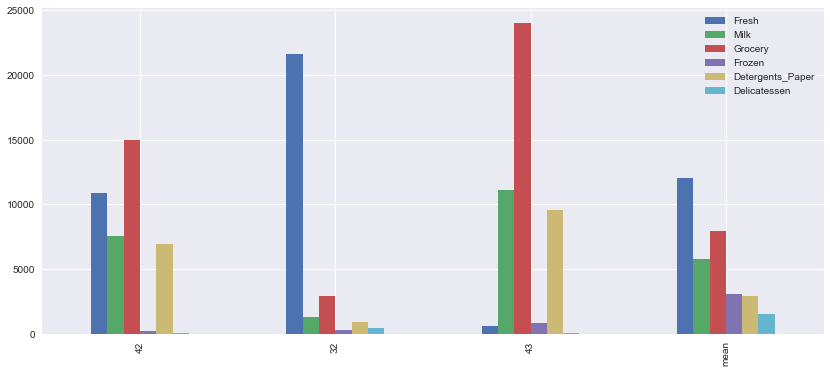

In [4]:
# Visualize samples along with the mean values in each category
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']
_ = samples_bar.plot(kind = 'bar', figsize=(14,6))

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*

**Answer:**

Sample 0: This sample is characterized by high values in Grocery and Detergents-paper (double the mean), and low values in Frozen and delicatessen (very low compared to the mean). It might be assumed as a restaurant.

- Fresh 11K is close to the mean 12K, above the median 8.5K
- Milk 7.6K is close to the mean 5.8K, above the median 3.6K
- Grocery 15K is almost double the mean 8K, triple to the the median 5K
- Frozen 0.2K is much lower than the mean 3K, lower than the median 1.5K
- Detergents-paper 7K is double the mean 3K, much higher than the median 0.8K
- Delicatessen 0K is lower than the mean 0.4K, same level to the median 0K

Sample 1: This shops purchases mainly fresh goods and purchases other goods much less. I assume this is a grocery store.

- Fresh 21K is double the mean 12K, trible the median 8.5K
- Milk 1.4K is lower than the mean 5.8K and the median 3.6K
- Grocery 3K is lower than the mean 8K and the median 5K
- Frozen 0.2K is lower than the mean 3K and the median 1.5K
- Detergents-paper 1K is lower than the mean 3K and close to the median 1K
- Delicatessen 0.4K is lower than the mean 1.5K and the median 1K

Sample 2: Grocery good, detergents_paper, and milk are their main purchase goods. Given relatively high quantity of detergents_paper and mikl, and low quantity of fresh goods, I assume this is a cafe.

- Fresh 1K is significantlly lower than than the mean 12K and hte median 8.5K
- Milk 11K is double the mean 5.8K and trible the median 3.6K
- Grocery 24K is significantly higher than the mean 8K and the median 5K
- Frozen 1K is lower than the mean 3K and close to the median 1k
- Detergents-paper 10K is significantly higher than the mean 3K and the median 1K
- Delicatessen 0K is lower than the mean 1.5K and hte median 1K

> Note: Using the median/quartiles would be much more appropriate than mean, since the median/quartiles are more robust to outliers.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [6]:
# Make a copy of the DataFrame, drop the given feature
new_data = data
y = new_data.Delicatessen
X = new_data.drop(['Delicatessen'], axis = 1, inplace = False)

In [7]:
# Split the data into training and testing sets 
# using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Report the score of the prediction using the testing set
score = r2_score(y_test, y_pred)
score

-11.023627900466765

### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  

**Answer:**

I tried to build a model to predict "Delicattessen" based on other features. It turns out the model fails to predict "Delicattessen" with negative R^2 score -11. This means that the feature is not dependent on the other featuers in the dataset and thus it uniquely captures spending characteristics of customers. This feature must remain in the dataset.

> Note: The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data.

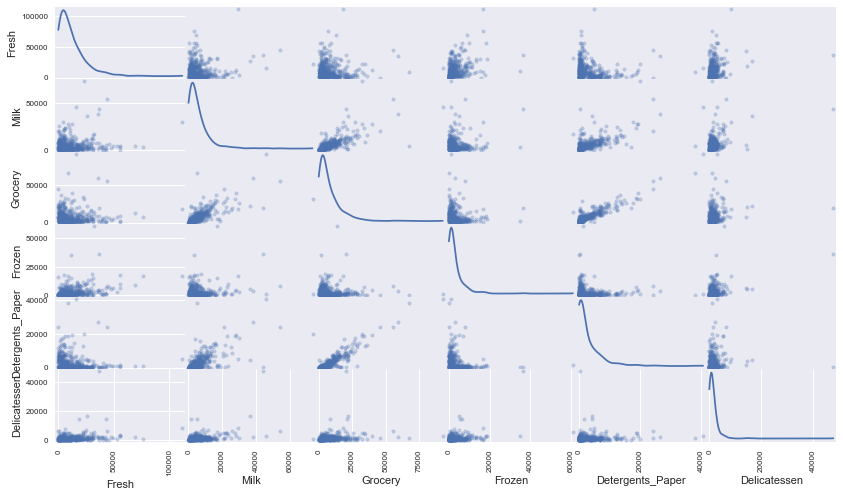

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  

**Answer:**

Detergents_Paper and Grocery seem to correlate each other with high correlation score 0.9244. This validates an observation of the scatter matrix above. Both of the features have highly skewed distribution to the right. Detergent_Paper concentrates between 0 - 1000 and Grocery concentrates between 0 - 5000.

On the otherhand, delicatessen, the feature I chose, doesn't show any correlation with other features. This is in line with my analysis in the feature importance section above: delicatessen uniquely describes a shopping patern of a customer in the dataset.

> Note: clustering algorithms discussed in this project work under the assumption that the data features are (roughly) normally distributed. Significant deviation from zero skewness indicates that we must apply some kind of normalisation to make the features normally distributed.

In [9]:
# get a matrix of correlations for all feature pairs
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


count      440.000000
mean      2881.493182
std       4767.854448
min          3.000000
25%        256.750000
50%        816.500000
75%       3922.000000
max      40827.000000
Name: Detergents_Paper, dtype: float64

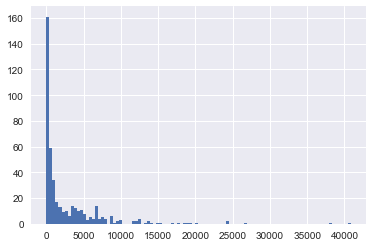

In [10]:
data.Detergents_Paper.hist(bins = 100)
data.Detergents_Paper.describe()

count      440.000000
mean      7951.277273
std       9503.162829
min          3.000000
25%       2153.000000
50%       4755.500000
75%      10655.750000
max      92780.000000
Name: Grocery, dtype: float64

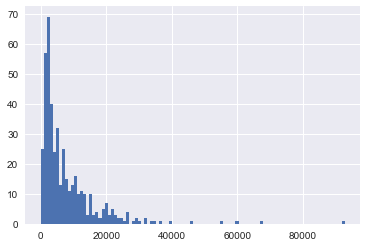

In [11]:
data.Grocery.hist(bins = 100)
data.Grocery.describe()

## 3. Data Preprocessing <a class="anchor" id="3-bullet"></a>
In this section, I preprocess the data to create a better representation of customers by performing a scaling on the data, detecting and removing outliers.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. Here, I took a simpler approach which is log transformation.

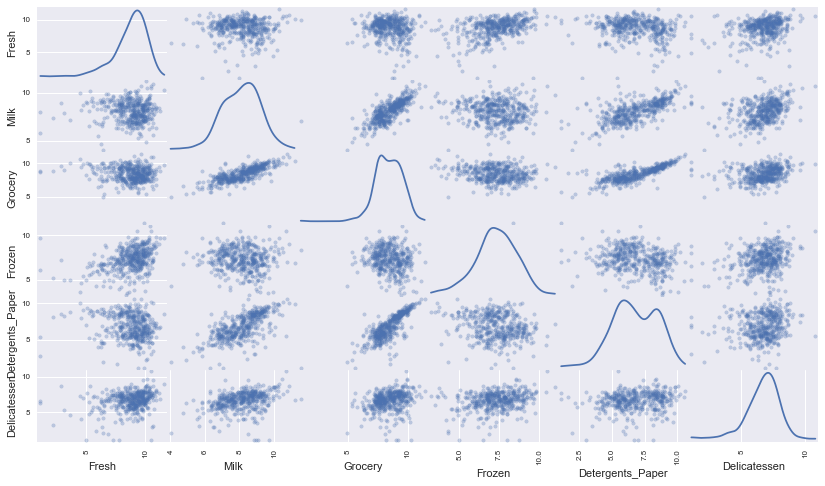

In [12]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

C:\Users\K\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


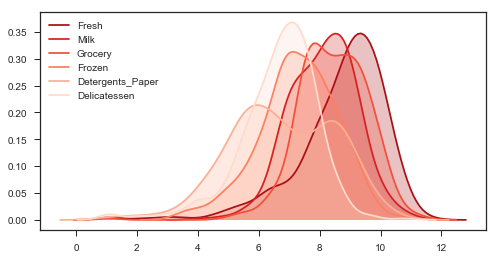

In [36]:
# Plot the log-transformed feature distributions for comparison
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    # plot densities of log data
    plt.figure(figsize=(8,4))
    for col in data.columns:
        sns.kdeplot(log_data[col], shade=True)
    plt.legend(loc='best');

In [13]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
1,9.981929,7.183871,7.967627,5.583496,6.822197,6.003887
2,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, I used [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [14]:
# For each feature find the data points with extreme high or low values
outliers = []
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range (IQR)
    # to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # append index of outliers to the list outliners
    outliers_idx = log_data[~((log_data[feature] >= Q1 - step) & 
                              (log_data[feature] <= Q3 + step))].index.tolist()
    outliers.extend(outliers_idx)
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & 
                       (log_data[feature] <= Q3 + step))])

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [15]:
# Select the indices for data points you wish to remove
from collections import Counter
cnt = Counter(outliers)
outliers_two_features = [item for item in cnt.keys() if cnt[item] > 1]
outliers_one_feature = [item for item in cnt.keys() if cnt[item] == 1]

# Remove the outliers
good_data = log_data.drop(
    log_data.index[outliers_two_features]).reset_index(drop = True)

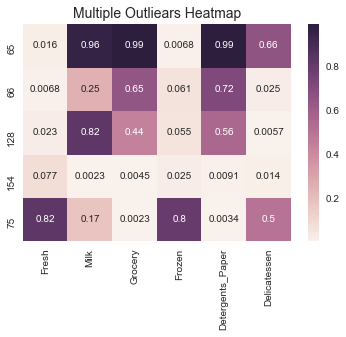

In [16]:
# Visualize outliers by heatmap
import matplotlib.pyplot as plt
import seaborn as sns
percentiles = data.rank(pct=True)
percentiles = percentiles.iloc[outliers_two_features]
plt.title('Multiple Outliears Heatmap', fontsize=14)
heat = sns.heatmap(percentiles, annot=True)
display(heat)

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

In [17]:
"outliners by one feature are {} and are {} rows".format(
    outliers_one_feature, len(outliers_one_feature))

'outliners by one feature are [81, 95, 96, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 356, 38, 57, 145, 175, 264, 325, 420, 429, 439, 161, 109, 137, 142, 183, 184, 187, 203, 233, 285, 289, 343] and are 37 rows'

In [18]:
"outliners by more than two features are {} and are {} rows".format(
    outliers_two_features, len(outliers_two_features))

'outliners by more than two features are [65, 66, 128, 154, 75] and are 5 rows'

I dropped the outliers for more than two features. This outlier treatment is because clustering algorithms work under the assumption that the data features are roughly normally distributed and outliers affect a distribution of data which ooutiers belong to. 
Given relatively small sample size 440, I kept the outliners by one feature.

## 4. Feature Transformation <a class="anchor" id="4-bullet"></a>

In this section I used principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, I can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved.

In addition to finding these dimensions, PCA also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

> Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

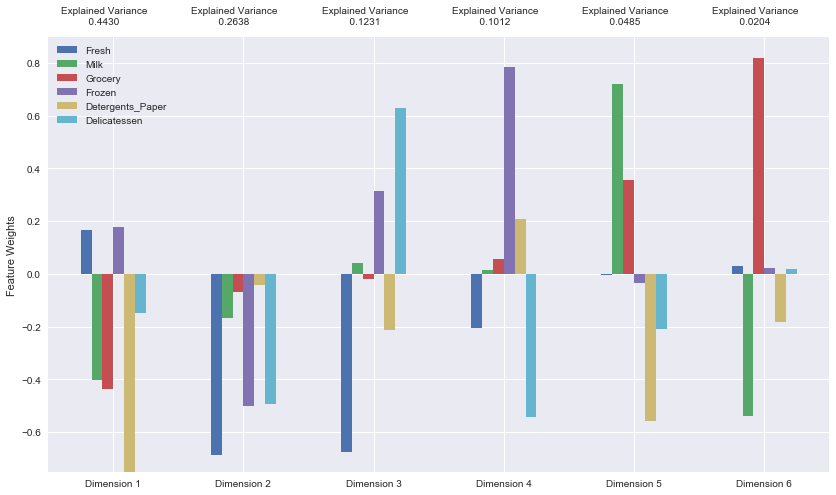

In [19]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [20]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.44302505,  0.70681723,  0.82988103,  0.93109011,  0.97959207,  1.        ])

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  

**Answer:**


As for the expalained variance ratio, first and second principal components in total explains 71% of the variance. Adding third and fourth principal components increases the explained variance ratio in total to 93%. This means that first and second explaines the majority of the variance and the third increases the score but its increase is limited to 20% which is less than the variance explained by two previous principal compnents respectively.

Assessment of each principal components: First principal component is made up of large negative weights in Detergents_papter, Grocery and Milk. It also mildly correlates with an increase in Fresh and Frozen. This pattern might represet spending in products used for a retaurant and a cafe. Second principal component is consisted of negative weights in Fresh, Frozen and Delicateccen. This spending pattern might be characterized by spending in household staples products that are purchased together. Third principal components strongly correlates with Fresh and Delicateccen, and midly correlates with Frozen. Fourth principal components strongly correlates with Grocery and Delicateccen. 

> Note: The dimensions represent patterns of spending that can both follow AND go against the direction of the category weights. E.g. The first 




### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [21]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.2146,1.7988,-3.2371,0.3088,0.5148,0.0568
1,0.5743,0.5709,-1.8390,-1.2760,-0.6685,0.0878
2,-3.1072,2.7017,-0.6386,1.8708,0.6452,0.1333


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: **Fewer dimensions used implies less of the total variance in the data is being explained.** Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [22]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [23]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.2146,1.7988
1,0.5743,0.5709
2,-3.1072,2.7017


Note: Confirmed that the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

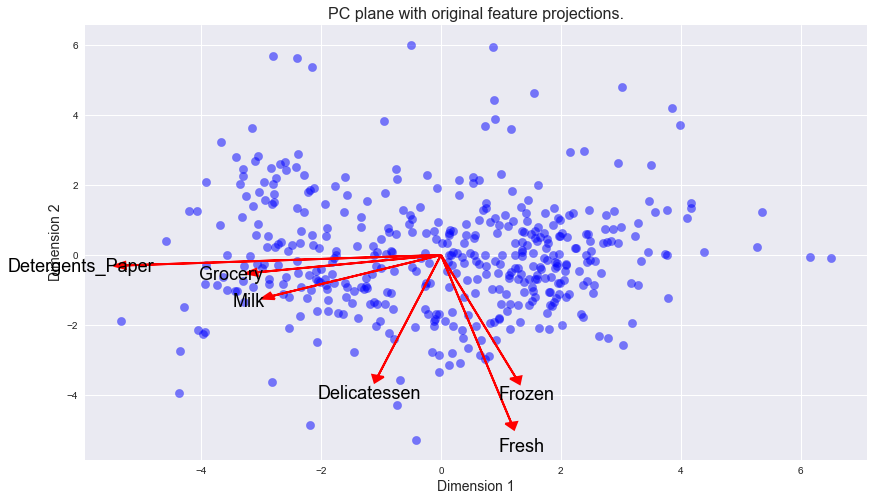

In [24]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

Note: Fresh is most strongly correlated with the first component and paper is with the second component.

## 5. Clustering <a class="anchor" id="5-bullet"></a>

In this section, I chose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. I then recovered specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale.

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

Advantages of K-Means:
- Running time
- Better for high dimentional data
- Easy to interpret and implement

Disadvantages of K-Means:
- Assumes the clusters as spherical, so does not work efficiently with complex geometrical shaped data (Mostly Non-Linear)
- Hard Assingment might lead to mis grouping

Advantages of Gaussian Mixture:
- Works well with non-linear geometric distributions as well
- Accomodates mixed membership: a point belongs to each cluster to a different degree (while in K-means, a point belongs to one and only one cluster)
- Does not bias the cluster sizes to have specific structures as does by K-Means

Disadvantages of Gaussian Mixutre:
- Slower since it has to incorporate information about the distributions of the data, thus it has to deal with the co-variance, mean, variance, and prior probabilities of the data, and also has to assign probabilities to belonging to each clusters.
- Difficult to interpret

Hard Assignment and Soft Assignment:

One of the largest difference between a K-Means and a Gaussian Mixture is how they assign a data point to a cluster. For K-means, we define a number of clusters first. Clustering of samples is done by minimizing the distancee between samples and the centroid. We are certain that particular points belong to particular centroid and then based on the least squares distance method, we will optimize the place of the centroid. This is called "Hard Assignment". For Gaussian Mixture, we are uncertain about how many groups there are and the data points where they belong or to which group. It uses probability of a sample to determine the feasibility of it belonging to a cluster. This is called "Soft Assingment".

Choice of algorithm:

I prefer interpretability to soft assignment. Thus I choose K-Means to cluster the dataset. 

>I refered these articles: https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian
https://www.quora.com/What-are-the-advantages-to-using-a-Gaussian-Mixture-Model-clustering-algorithm
https://www.quora.com/What-are-the-advantages-of-K-Means-clustering

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. 

However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=2, random_state=10).fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.cluster_centers_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
score

0.42628101546910846

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

Silhouette score is 0.427 for 2 clusters, 0.397 for 3, 0.331 for 4, and 0.339 for 5. 2 clusters has the best score.

> Note: Since in unsupervised learning processes, we do not have a ground truth to generally compare to, this makes evaluating a clustering model quite interesting and there's a lot of literature on this, some other methods to consider are the information criterion methods such as AIC or BIC. For some info on this see

### Cluster Visualization
Once I've chosen the optimal number of clusters for the clustering algorithm using the scoring metric above, I can now visualize the results by executing the code block below.

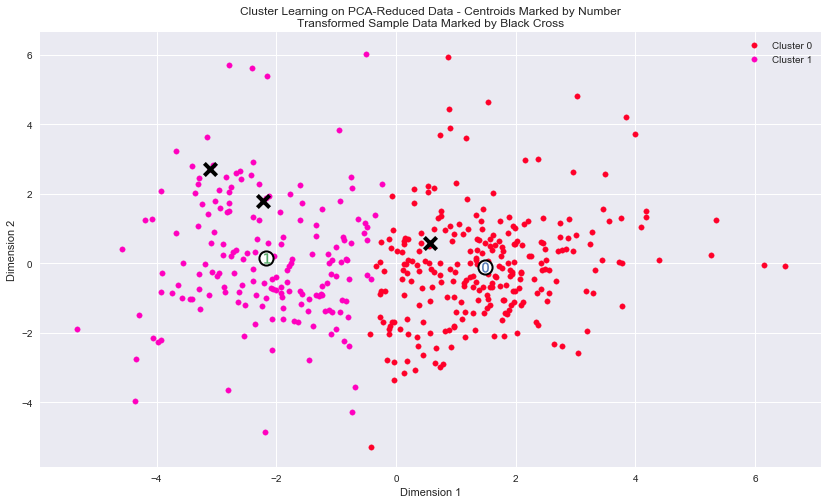

In [26]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [27]:
# Check the centers again
centers

array([[ 1.49093664, -0.10743169],
       [-2.17322969,  0.15659534]])

In [28]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


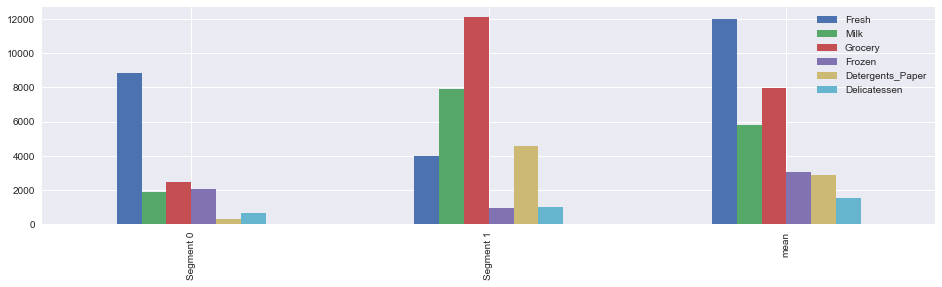

In [29]:
# visualize two centers with the mean
true_centers = true_centers.append(data.describe().ix["mean"])
true_centers.plot(kind = 'bar', figsize = (16, 4))

In [30]:
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.000000,1897.000000,2477.000000,2088.000000,294.000000,681.000000
Segment 1,4005.000000,7900.000000,12104.000000,952.000000,4561.000000,1036.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*

**Answer:**

Segment 0: Overall this segment shows that lower or close values against a mean and a median for almost all features. Low detergents_paper purchase and relatively lower milk indicate this is not a restaurant or a cafe. Instead, I think this is a grocery store or a super markets. Thus, so is cluster 0.

- Fresh: 9K is lower than the mean 12K and close to the median 8.5K
- Milk: 2K is lower than the mean 6K and relatively close to the median 3.6K
- Grocery: 2K is much lower than the mean 8K and the median 5K
- Frozen: 2K is close to the mean 3K and the median 2K
- Detergents_Paper: 0.3K is lower than the mean 3K and the median 1K
- Delicatessen: 1K is close to both the mean 1.5K and the median 1K

Segment 1: This segment spends on fresh, milk, Grocery, and Detergents_paper more than the median and the mean. Detergents_paper is a good sign that this establishment is a restaurant or a cafe. Thus, so is cluster 1.

- Fresh: 4K is significantly lower than the mean 12K and the median 8.5K
- Milk: 8K is higher than the the mean 6K and the median 3.6K
- Grocery: 12K is higher than the mean 8K and the median 5K
- Frozen: 1K is lower than the mean 3K and the median 1.5K
- Detergents_paper: 4.5K is higher than the mean 3K and the median 1K
- Delicatessen: 1K is close to both the mean 1.5K and the median 1K

### Question 9
*For each sample point, which customer segment from* Question 8 *best represents it? Are the predictions for each sample point consistent with this?*

**Answer:**

Below visualizations illustrate which customer best represent each sample. For sample 0, the values for 'Fresh', 'Milk', 'Grocery', and 'Detergent_Paper' are high and resemble segment 1, the cluster 1 center in those categories.

Sample 1 is with the high value for 'Fresh' and the low vlaues in other categories. This is in line with segment 0, the cluster 0 center overall.

Sample 2 have high values for 'Milk', 'Grocery' and 'Detergents_Paper' and low values for other categories. This pattern resembles segment 1, the cluster 1 cetner.

In [31]:
samples.index = ["Sample 0", "Sample 1", "Sample 2"]

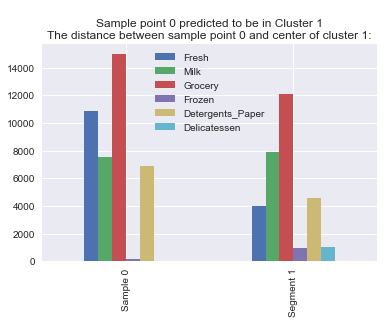

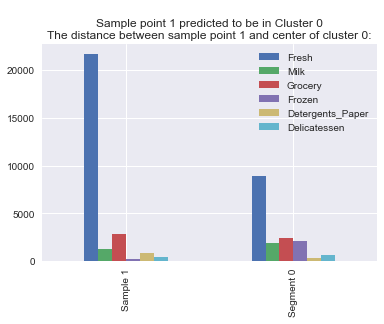

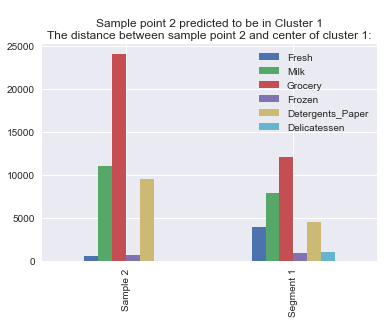

In [32]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    title1 = "\nSample point {} predicted to be in Cluster {}\n".format(i, pred)
    title2 = "The distance between sample point {} and center of cluster {}:".format(i, pred)
    samples.iloc[i:i+1].append(true_centers.iloc[pred:pred+1]).plot(
        kind = 'bar', title=title1 + title2)

## 6. Conclusion <a class="anchor" id="6-bullet"></a>

In this final section, I investigated ways that I could make use of the clustered data. First, I considered how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, I considered how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, I compared the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

*How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  

**Answer:**

The whole distributor can conduct an AB test in each of the two segments. That is, for segment 0, the distributor can randomly split the customers in this segment into two, and try the 3 day distribution to the experiment group, while for segment zero control group, the distributor continues with the current 5 day schedule. 

> Note: We wouldn't perform the experiment on all customers in a segment or even half of them in reality. Instead, we would take small representative samples from each cluster and perform our expriment on those.

The wholesale distributor can then test whether there is a statistically significant difference in a metric of their choice (e.g cost savings) between the control and experiment groups. 

From the A/B test they can decide whether to launch the three day delivery system in segment 0. The wholesale distributor can then do another A/B test for segment 1, and determine whether to launch the change for segment 1.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*

**Answer:**

Aftering completing A/B testing, we have the data of customers that react positively and negatively to train with. Next step is to build a supervised learner with the dataset. The learners is to predict whether a customer react to the service change positively. 

Next step is use the clustering model we used to classify new customers to two clusters. With their estimated product spending and the cluster they belong to as features, the learner predicts an appropriate delivery service for a new customer.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

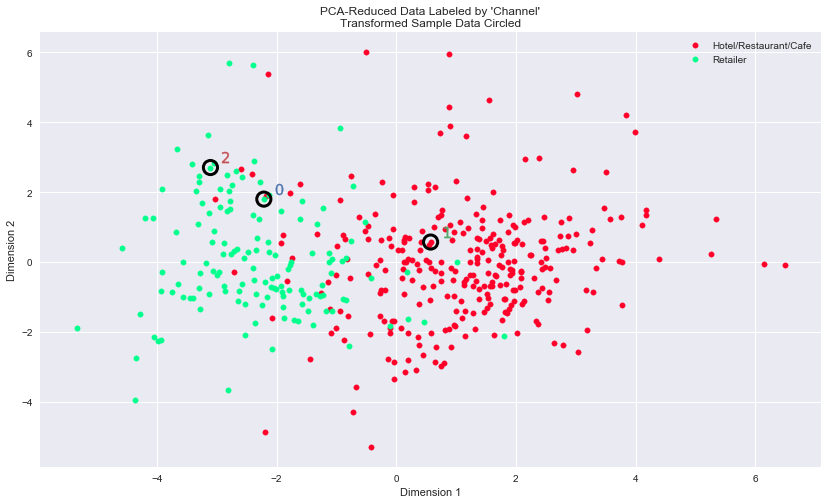

In [33]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers_two_features, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

Overall, prior visualization for two clusters is aligned with the new visualizaiton above. This means that the K-means clustering algorithm works properly to classify two categories of establishments.

Look at three samples we picked up previously. Sample 0 classified as cluster 1 (supermarket/grocery store) by K-means is actually a 'Retailer'. Same is true to Sample 2. Sample 1 classified as cluster 0 (restaurant/cafe) by K-means is a 'Hotel/Retailer/Cafe'. This also supports effectiveness of our model.